In [1]:
import csv, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.arima_process import ArmaProcess

In [2]:
time_max = 200

df_apple = pd.read_csv('../data/apple_prices.csv', names=['Price'], header=None)
apple = df_apple.Price.tolist()
apple = apple[:time_max]

In [3]:
mean = 0
std = 1 
num_samples = 200
w_noises = np.random.normal(mean, std, size=num_samples)

In [4]:
def arma_filter(thetas, phis, x):
    phis_len = len(phis)
    thetas_len = len(thetas)
    x_len = len(x)
    y = np.zeros(x_len)

    for i in range(x_len):
        tmp = 0
        # Moving Average
        for j in range(1, thetas_len):
            if (i-j) < 0:
                continue
            tmp += thetas[j] * x[i-j]
        # Autoregressive
        for k in range(1, phis_len):
            if (i-k) < 0:
                continue
                
            # calculating autoregressive is a recursive process
            # issue: maintain mulciplication levels of y[i-k] and y[i]
            tmp -= phis[k] * y[i-k]
        
        y[i] = tmp

    return y

In [5]:
# thetas: MA coefficients
# phis: AR coefficients
def arma_to_ma(thetas, phis, order):
    t = len(thetas)
    p = len(phis)
    result = np.zeros(order)
    phis = [-x for x in phis]
    
    if (t < order):
        for i in range(t, order):
            thetas.append(0)
    if (p < order):
        for i in range(p, order):
            phis.append(0)
    
    result[0] = 1
    for i in range(order-1):
        result[i+1] = thetas[i+1]
        
        # issue 1: min operation
        for j in range((min(i, p)+1)):
            # issue 2: multiplication levels of result[i+1] and result[i-j]*phis[j+1] must be the same
            # to allow addition
            # calculating result is a recursive process
            result[i+1] = result[i+1] + result[i-j]*phis[j+1]
        
    return result

In [6]:
# def ARMAtoMA(phis, thetas, m):
#     p = len(phis)
#     q = len(thetas)

#     res = [0]*m
    
#     for i in range(m):
#         if i < q:
#             tmp = thetas[i]
#         else:
#             tmp = 0.0
#         for j in range(min(i+1, p)):
#             if i-j-1 >= 0:
#                 tmp += phis[j]*res[i-j-1]
#             else:
#                 tmp += phis[j]*1.0
#         res[i] = tmp;
#     return res;

In [7]:
# maparams = [.65, .35]
# arparams = [1, -.75, .25]
# lags = 10

maparams = [0.35]
arparams = [1, -0.65]
lags = 10

In [8]:
# stats model arma2ma
arma_process = ArmaProcess(arparams, [1]+maparams)
arma2ma_coeff = arma_process.arma2ma(lags=lags)
# arma2ma_coeff = arma2ma_coeff[1:]
print(arma2ma_coeff)

[1.         1.         0.65       0.4225     0.274625   0.17850625
 0.11602906 0.07541889 0.04902228 0.03186448]


In [9]:
#custom arma to ma
ma_cof_1 = arma_to_ma(maparams, arparams, lags)
# ma_cof_2 = ARMAtoMA(arparams, maparams, lags)
print(ma_cof_1)
# print(ma_cof_2)

[1.         0.65       0.4225     0.274625   0.17850625 0.11602906
 0.07541889 0.04902228 0.03186448 0.02071191]


In [10]:
arma_wn = arma_filter([1]+maparams, arparams, w_noises)
ma_wn = arma_filter(ma_cof_1, [1], w_noises)

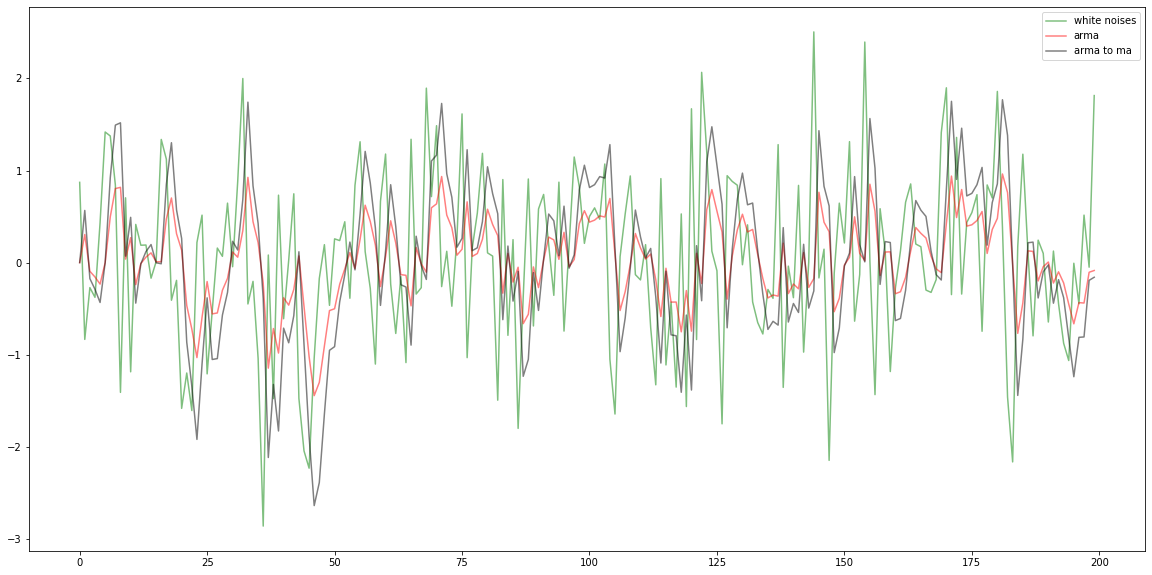

In [11]:
plt.figure(figsize=(20, 10))
plt.plot(w_noises, color='green', alpha=0.5, label='white noises')
plt.plot(arma_wn, color='red', alpha=0.5, label='arma')
plt.plot(ma_wn, color='black', alpha=0.5, label='arma to ma')
plt.legend()
plt.show()

In [12]:
arma_apple = arma_filter([1]+maparams, arparams, apple)
ma_apple = arma_filter(ma_cof_1, [1], apple)
# ma_apple_2 = arma_filter([1.], ma_cof_2, apple)

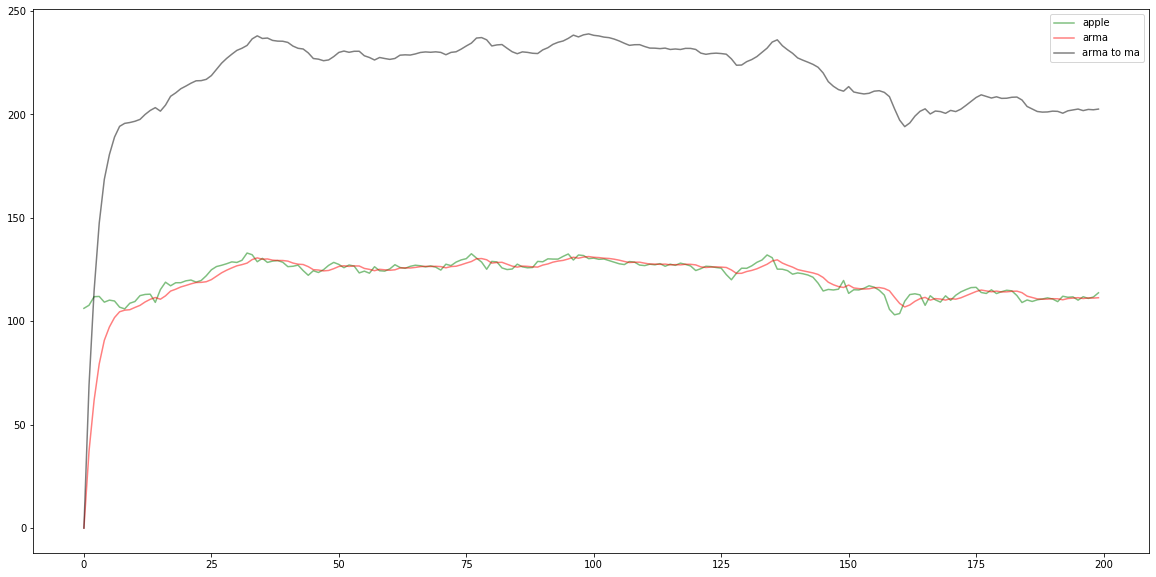

In [13]:
plt.figure(figsize=(20, 10))
plt.plot(apple, color='green', alpha=0.5, label='apple')
plt.plot(arma_apple, color='red', alpha=0.5, label='arma')
plt.plot(ma_apple, color='black', alpha=0.5, label='arma to ma')
# plt.plot(ma_apple_2, color='yellow', alpha=0.5, label='arma to ma 2')
plt.legend()
plt.show()